# Test Different MLP
Here we will test differet versions. Maybe running the model multiple times and averaging the results. 

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns
sns.set()

seed_val = 97

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [7]:
def split_data(dataset, seed, train_ratio=0.6, shuffle=True):
    if shuffle:
        dataset = dataset.sample(frac=1, random_state=seed)#.reset_index(drop=True)

    train_dataset = dataset.sample(frac=train_ratio, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    
    return train_dataset, test_dataset

def add_bias(data):
    N1 = np.shape(data)[0]
    N2 = np.shape(data)[1]
    a = -1*np.ones((N1,N2+1))
    a[:,:-1] = data
    return a

def add_noise(dataset, target_column=4, noise_var=0.01, input_n=False, output_n=False):
    """ Called on DATAFRAME training data. """
    features = dataset.to_numpy()[:,0:target_column]
    labels = np.reshape(dataset.to_numpy()[:,target_column], (-1,1))
    
    if input_n:
        noise = np.reshape(np.random.normal(0,0.01,np.shape(features)[0]*np.shape(features)[1]),(np.shape(features)[0],np.shape(features)[1]))
        features = features + noise 

    if output_n:
        noise = np.reshape(np.random.normal(0,0.01,np.shape(labels)[0]*np.shape(labels)[1]),(np.shape(labels)[0],np.shape(labels)[1]))
        labels = labels + noise
    return features, labels

Text(0.5, 1.0, 'Testing Data')

<Figure size 432x288 with 0 Axes>

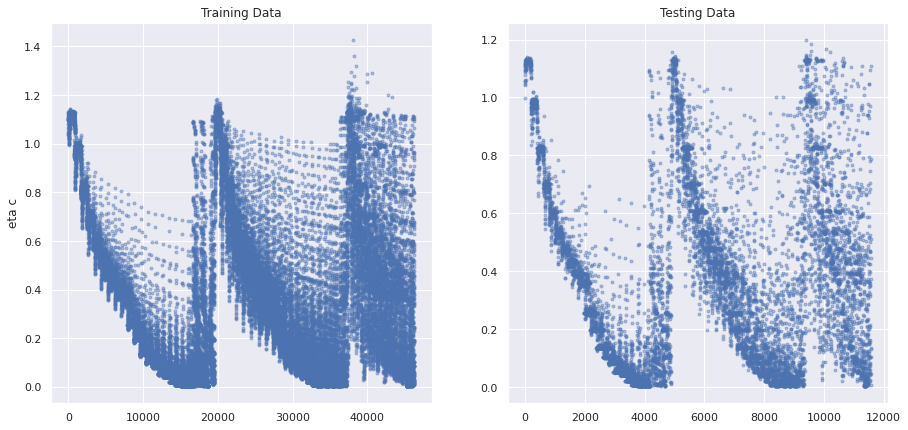

In [22]:
name = "LIM_scaled.csv"
name = "data.csv"

dataset = pd.read_csv(name)
# data2.describe().transpose()
dataset.pop("Unnamed: 0")

# scale the data
scaled_dataset = dataset.copy()
scaled_dataset['b1'] = MaxAbsScaler().fit_transform(dataset['b1'].values.reshape(-1,1))
scaled_dataset['a2'] = MaxAbsScaler().fit_transform(dataset['a2'].values.reshape(-1,1))
scaled_dataset['RatioTotalArea'] = MaxAbsScaler().fit_transform(dataset['RatioTotalArea'].values.reshape(-1,1))
scaled_dataset['frac'] = MaxAbsScaler().fit_transform(dataset['frac'].values.reshape(-1,1))

# split the data
train_dataset, test_dataset = split_data(scaled_dataset.copy(), seed_val, train_ratio=0.8)

# sort the data to check representation
sorted_train = train_dataset.sort_index()
sorted_test = test_dataset.sort_index()

# check representation
fig = plt.figure()
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax[0].scatter(x=np.arange(len(sorted_train)), y=sorted_train['eta c'], marker='.', alpha=0.4)
ax[1].scatter(x=np.arange(len(sorted_test)), y=sorted_test['eta c'], marker='.', alpha=0.4)
ax[0].set_ylabel("eta c")
ax[0].set_title("Training Data")
ax[1].set_title("Testing Data")


Organise the data for training.

In [10]:
train_features = train_dataset.to_numpy()[:,0:4]
train_labels = train_dataset.to_numpy()[:,4]

# for noisey TRAINING data use this instead 
# train_features, train_labels = add_noise(train_dataset, noise_var=0.001, output_n=True)

sorted_test = test_dataset.sort_index()
test_features = sorted_test.to_numpy()[:,0:4]
test_labels = sorted_test.to_numpy()[:,4]

X = train_features.copy()
Y = train_labels.copy()

ML Algo class.

In [42]:
class MLP_Regression():
    def __init__(self, input_shape, nodes=30):
        self.model = Sequential()
        self.model.add(Dense(nodes, input_shape=(input_shape,), activation="relu", use_bias=True))

    def learning_rate(self, initial_lr=1e-2, decay_steps=1e5, decay_rate=0.9):
        self.lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate)

    def optimizer(self, momentum=0.1):
        self.optimizer = keras.optimizers.SGD(learning_rate=self.lr_schedule, momentum=momentum, nesterov=False)

    def add_layer(self, num_nodes):
        self.model.add(Dense(num_nodes, activation="relu", use_bias=True))
    
    def add_output_layer(self, out_nodes):
        self.model.add(Dense(out_nodes, activation="relu", use_bias=True))

    def add_dropout(self, rate, seed):
        self.model.add(keras.layers.Dropout(rate=rate, seed=seed))

    def compileModel(self, optimizer, loss="mean_squared_error", metrics=["MSE","MAE", "MAPE"]):
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def train_model(self, X, Y, early_stopping=True, patience=3, epochs=10, batch_size=500, vali_split=0.2):
        if early_stopping:
            earlystop_callback = EarlyStopping(monitor="loss", min_delta=0, patience=patience, mode="min", restore_best_weights=True)
            hist = self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=vali_split, callbacks=[earlystop_callback])
            self.history = pd.DataFrame(hist.history)
            self.history['epoch'] = hist.epoch
        else:
            hist = self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=vali_split)
            self.history = pd.DataFrame(hist.history)
            self.history['epoch'] = hist.epoch

    def show_training_errors(self):
        hist = self.history

        fig1 = plt.figure()
        fig1, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

        ax[0][0].set_xlabel('Epoch')
        ax[0][0].set_ylabel('MSE')
        ax[0][0].plot(hist['epoch'], hist['MSE'], label='Train Error')
        ax[0][0].plot(hist['epoch'], hist['val_MSE'], label='Val Error')
        ax[0][0].legend()
        ax[0][0].set_title("MSE Error")

        ax[0][1].set_xlabel('Epoch')
        ax[0][1].set_ylabel('MAE')
        ax[0][1].plot(hist['epoch'], hist['MAE'], label='Train Error')
        ax[0][1].plot(hist['epoch'], hist['val_MAE'], label='Val Error')
        ax[0][1].legend()
        ax[0][1].set_title("MAE Error")

        ax[1][0].set_xlabel('Epoch')
        ax[1][0].set_ylabel('MAPE')
        ax[1][0].plot(hist['epoch'], hist['MAPE'], label='Mean Abs {} Error'.format("%"))
        ax[1][0].legend()
        ax[1][0].set_title("MAPE")

    def test(self, test_features, test_labels):
        test_input = test_features
        test_output = np.reshape(test_labels, (-1,1))
        prediction = self.model.predict(test_input)

        fig2 = plt.figure()
        plt.plot(np.arange(len(test_output)), test_output, label="TestData")
        plt.plot(np.arange(len(prediction)), prediction, label="Prediction", alpha=0.4)
        plt.legend()
        plt.title("Model Prediction")

Start tests here.

In [44]:
# define input and output dimensions
out_nodes = 1
in_features = 4 

# setup algo
my_model = MLP_Regression(in_features, nodes=30)
my_model.learning_rate(initial_lr=1e-2, decay_steps=1e5, decay_rate=0.9)
my_model.optimizer(momentum=0.1)

# add layers
my_model.add_layer(23)
my_model.add_output_layer(out_nodes)

# run algo
my_model.compileModel(my_model.optimizer)
my_model.train_model(X,Y, epochs=10)

Epoch 1/10
65/65 [==============================] - 0s 4ms/step - loss: 0.0487 - MSE: 0.0487 - MAE: 0.1773 - MAPE: 242.8706 - val_loss: 0.0384 - val_MSE: 0.0384 - val_MAE: 0.1615 - val_MAPE: 286.0146
Epoch 2/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0362 - MSE: 0.0362 - MAE: 0.1563 - MAPE: 281.9919 - val_loss: 0.0357 - val_MSE: 0.0357 - val_MAE: 0.1546 - val_MAPE: 271.2847
Epoch 3/10
65/65 [==============================] - 0s 2ms/step - loss: 0.0341 - MSE: 0.0341 - MAE: 0.1505 - MAPE: 267.9637 - val_loss: 0.0340 - val_MSE: 0.0340 - val_MAE: 0.1497 - val_MAPE: 258.6130
Epoch 4/10
65/65 [==============================] - 0s 2ms/step - loss: 0.0327 - MSE: 0.0327 - MAE: 0.1463 - MAPE: 256.9149 - val_loss: 0.0328 - val_MSE: 0.0328 - val_MAE: 0.1460 - val_MAPE: 246.7480
Epoch 5/10
65/65 [==============================] - 0s 2ms/step - loss: 0.0316 - MSE: 0.0316 - MAE: 0.1430 - MAPE: 247.2157 - val_loss: 0.0318 - val_MSE: 0.0318 - val_MAE: 0.1430 - val_MAPE: 242.5501


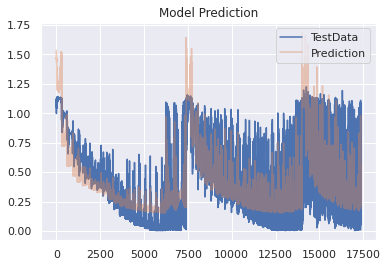

In [45]:
my_model.test(test_features,test_labels)